In [1]:
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE

import time
start_time = time.time()
%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Set Nan values of df.waterfront to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)

#Drop id, date, and view
cols_to_drop = ['id']
df.drop(cols_to_drop, axis=1, inplace=True)
df.dropna(subset = ['view'], inplace = True)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['Month'] = df['date'].apply(lambda date: date.month)
df['Year'] = df['date'].apply(lambda date: date.year)
df['bathrooms'] = np.round(df['bathrooms'])
df['floors'] = np.round(df['floors'])

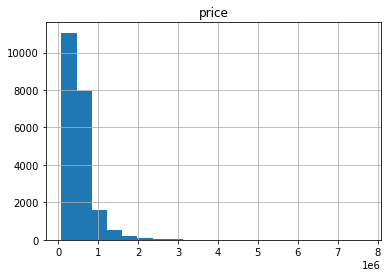

In [6]:
df.hist('price', bins=20);

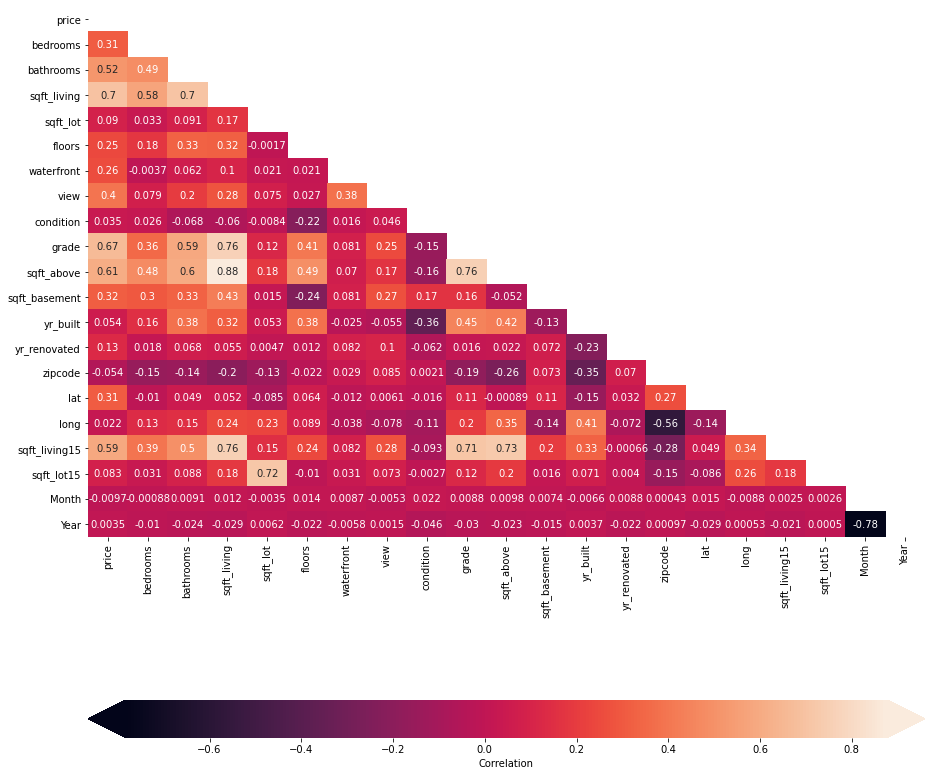

In [7]:
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            df.corr(), 
            ax=ax, 
            annot=True, 
            mask=np.triu(np.ones_like(df.corr(), dtype=bool)),
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

The most correlated feature to price is sqft_living (.7).  We will use this feature to establish a baseline model.

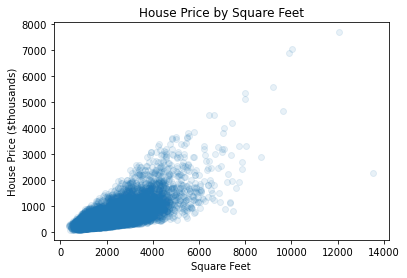

In [8]:
fig, ax = plt.subplots()
ax.scatter(df.sqft_living, df.price, alpha=.1)
ax.set_xlabel('Square Feet')
ax.set_yticks(range(0,9000000,1000000))
ax.set_yticklabels(range(0,9000,1000))
ax.set_ylabel('House Price ($thousands)')
ax.set_title('House Price by Square Feet');

## Baseline Model

In [9]:
#Statsmodels
y = df.price
X = sm.add_constant(df.sqft_living)
stats_model_baseline = sm.OLS(endog=y, exog=X).fit()
stats_model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:22:55   Log-Likelihood:            -2.9912e+05
No. Observations:               21534   AIC:                         5.982e+05
Df Residuals:                   21532   BIC:                         5.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.215e+04   4404.521     -9.570      0.000   -5.08e+04   -3.35e+04
sqft_living   279.9321      1.938    144.473      0.000     276.134     283.730
==============================================================================
Omnibus:                    14582.265   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516142.289
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      26.331   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

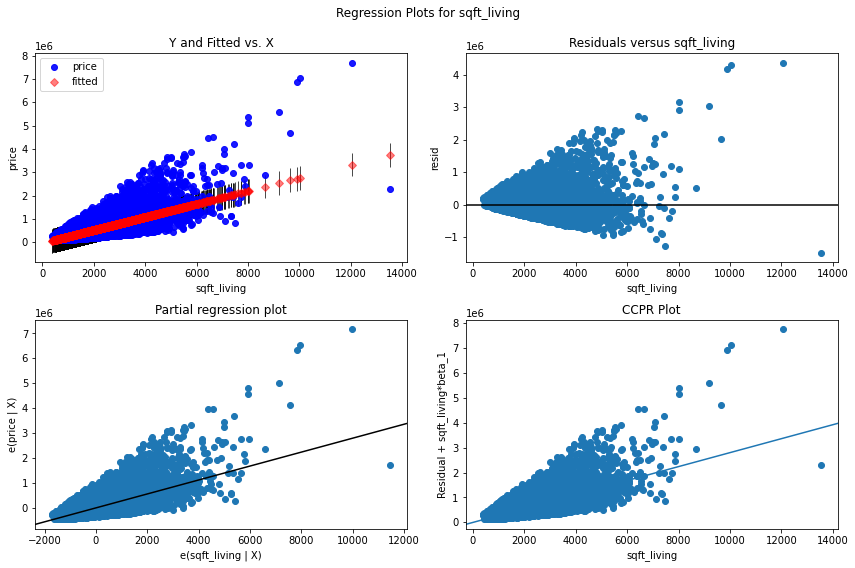

In [10]:
sm.graphics.plot_regress_exog(stats_model_baseline, 'sqft_living', fig = plt.figure(figsize=(12,8)));

In [11]:
#SkLearn
y = df.price
X = df.sqft_living.values.reshape(-1,1)
sk_model_baseline = LinearRegression()
sk_model_baseline.fit(X, y)
score = sk_model_baseline.score(X, y)
coef = sk_model_baseline.coef_
intercept = sk_model_baseline.intercept_
print('R2 score:              ', round(score, 3))
print('sqft_living coef.:     ', round(coef[0], 3))
print('Intercept:            ', round(intercept, 2))

R2 score:               0.492
sqft_living coef.:      279.932
Intercept:             -42152.95


# OLS

In [12]:
# Change the X to the revelant colums
X = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
       'grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15']]
y = df['price']

In [13]:
# X = sm.add_constant(X)

# stats_model_1 = sm.OLS(endog=y, exog=X).fit()
# stats_model_1.summary()

# SkLearn Starts Here

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

In [15]:
ss = StandardScaler()

In [16]:
X = ss.fit_transform(X)

In [17]:
rf = RandomForestRegressor()

In [18]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [19]:
score_rf = rf.score(X_train,y_train)

In [20]:
pred_rf = rf.predict(X_test)

In [21]:
mae_rf = mean_absolute_error(y_test,pred_rf)

In [22]:
rmse_rf = mean_squared_error(y_test,pred_rf, squared=False)

In [23]:
print('Mae: ',mae_rf)
print('Rmse: ',rmse_rf)

Mae:  123537.1819155417
Rmse:  198442.85367530014


In [24]:
print(score_rf)

0.9587381202561673


# Linear Regression

In [25]:
lr = LinearRegression()

In [26]:
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
score_lr = lr.score(X_train, y_train)
score_lr

0.60705175030273

In [28]:
lr.coef_[0]

-40627.21088759514

In [29]:
lr.intercept_

-699831.3656262236

# POLYNOMIAL REGRESSION

In [30]:
poly = PolynomialFeatures(degree=3)

In [31]:
X_train_poly = poly.fit_transform(X_train)

In [33]:
X_test_poly = poly.transform(X_test)

In [34]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [35]:
score_poly = lr.score(X_train_poly, y_train)
score_poly

0.7324582605934553

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))